<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia


Estimated time needed: **40** minutes


In this lab, you will be performing web scraping to collect Falcon 9 historical launch records from a Wikipedia page titled `List of Falcon 9 and Falcon Heavy launches`

https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/Falcon9_rocket_family.svg)


Falcon 9 first stage will land successfully


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


More specifically, the launch records are stored in a HTML table shown below:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_1_L2/images/falcon9-launches-wiki.png)


  ## Objectives
Web scrap Falcon 9 launch records with `BeautifulSoup`:
- Extract a Falcon 9 launch records HTML table from Wikipedia
- Parse the table and convert it into a Pandas data frame


First let's import required packages for this lab


In [ ]:
!pip3 install beautifulsoup4
!pip3 install requests

In [ ]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

and we will provide some helper functions for you to process web scraped HTML table


In [ ]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


To keep the lab tasks consistent, you will be asked to scrape the data from a snapshot of the  `List of Falcon 9 and Falcon Heavy launches` Wikipage updated on
`9th June 2021`


In [ ]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

Next, request the HTML page from the above URL and get a `response` object


### TASK 1: Request the Falcon9 Launch Wiki page from its URL


First, let's perform an HTTP GET method to request the Falcon9 Launch HTML page, as an HTTP response.


In [ ]:
# use requests.get() method with the provided static_url and headers
# assign the response to a object
# Faz a requisição GET
response = requests.get(static_url, headers=headers)

# Verifica o status
print("Status code:", response.status_code)

# Mostra parte do conteúdo retornado
print(response.text[:500])


Status code: 200
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vect


Create a `BeautifulSoup` object from the HTML `response`


In [ ]:
# Use BeautifulSoup() to create a BeautifulSoup object from a response text content
soup = BeautifulSoup(response.text, "html.parser")

# Visualiza os primeiros elementos para confirmar
print(soup.prettify()[:500])


<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vect


Print the page title to verify if the `BeautifulSoup` object was created properly


In [ ]:
# Use soup.title attribute

In [ ]:
# Imprime o título da página
print(soup.title.string)

List of Falcon 9 and Falcon Heavy launches - Wikipedia


### TASK 2: Extract all column/variable names from the HTML table header


Next, we want to collect all relevant column names from the HTML table header


Let's try to find all tables on the wiki page first. If you need to refresh your memory about `BeautifulSoup`, please check the external reference link towards the end of this lab


In [ ]:
# Use the find_all function in the BeautifulSoup object, with element type `table`
# Assign the result to a list called `html_tables`
# Encontra todas as tabelas da página
html_tables = soup.find_all("table")

# Verifica quantas tabelas foram encontradas
len(html_tables)

25

Starting from the third table is our target table contains the actual launch records.


In [ ]:
# Let's print the third table and check its content
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

You should able to see the columns names embedded in the table header elements `<th>` as follows:


```
<tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11">[b]</a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12">[c]</a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 9 first-stage landing tests">Booster<br/>landing</a>
</th></tr>
```


Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one


In [ ]:
# Encontra todos os elementos <th> da tabela
th_elements = first_launch_table.find_all("th")

column_names = []

# Itera sobre cada <th> e extrai o nome da coluna
for th in th_elements:
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)


# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names


Check the extracted column names


In [ ]:
print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


## TASK 3: Create a data frame by parsing the launch HTML tables


We will create an empty dictionary with keys from the extracted column names in the previous task. Later, this dictionary will be converted into a Pandas dataframe


In [ ]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Next, we just need to fill up the `launch_dict` with launch records extracted from table rows.


Usually, HTML tables in Wiki pages are likely to contain unexpected annotations and other types of noises, such as reference links `B0004.1[8]`, missing values `N/A [e]`, inconsistent formatting, etc.


To simplify the parsing process, we have provided an incomplete code snippet below to help you to fill up the `launch_dict`. Please complete the following code snippet with TODOs or you can choose to write your own logic to parse all launch tables:


In [26]:
extracted_row = 0

# Extract each table
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    # get table row
    for rows in table.find_all("tr"):

        # check if first table heading is a number corresponding to a launch number
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False

        # get table elements
        row = rows.find_all('td')

        # if it is a number, save cells in dictionary
        if flag:
            extracted_row += 1

            # Flight Number
            launch_dict['Flight No.'].append(flight_number)

            # Date and Time
            datatimelist = date_time(row[0])

            # Date
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)

            # Time
            time = datatimelist[1]
            launch_dict['Time'].append(time)

            # Booster version
            bv = booster_version(row[1])
            if not bv:
                bv = row[1].a.string
            launch_dict['Version Booster'].append(bv)

            # Launch Site
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)

            # Payload
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)

            # Payload Mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)

            # Orbit
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)

            # Customer
            if row[6].a:
              customer = row[6].a.string
            else:
              customer = row[6].text.strip()
            launch_dict['Customer'].append(customer)

            # Launch outcome
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)

            # Booster landing
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)


After you have fill in the parsed launch record values into `launch_dict`, you can create a dataframe from it.


In [27]:
df= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
222,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10657,Success,9 May 2021,06:42
223,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8660,Success,15 May 2021,22:56
224,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2665,Success,26 May 2021,18:59
225,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1668,Success,3 June 2021,17:29


We can now export it to a <b>CSV</b> for the next section, but to make the answers consistent and in case you have difficulties finishing this lab.

Following labs will be using a provided dataset to make each lab independent.


In [29]:
!pip install graphviz

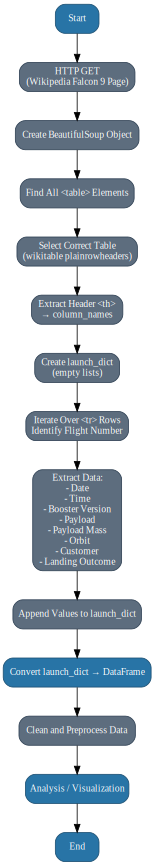

In [32]:
from graphviz import Digraph

dot = Digraph("Falcon9_WebScraping", comment="Flowchart of Falcon 9 Web Scraping Process")

# General style
dot.attr(rankdir='TB', size='8,12', bgcolor="#FFFFFF")

# Node styles
node_style = {
    "shape": "box",
    "style": "rounded,filled",
    "color": "#2E4053",
    "fontcolor": "white",
    "fontsize": "12",
    "fillcolor": "#5D6D7E"
}

highlight_style = {
    "shape": "box",
    "style": "rounded,filled",
    "color": "#1B4F72",
    "fontcolor": "white",
    "fontsize": "12",
    "fillcolor": "#2874A6"
}

# Nodes
dot.node("A", "Start", **highlight_style)
dot.node("B", "HTTP GET\n(Wikipedia Falcon 9 Page)", **node_style)
dot.node("C", "Create BeautifulSoup Object", **node_style)
dot.node("D", "Find All <table> Elements", **node_style)
dot.node("E", "Select Correct Table\n(wikitable plainrowheaders)", **node_style)
dot.node("F", "Extract Header <th>\n→ column_names", **node_style)
dot.node("G", "Create launch_dict\n(empty lists)", **node_style)
dot.node("H", "Iterate Over <tr> Rows\nIdentify Flight Number", **node_style)
dot.node("I", "Extract Data:\n- Date\n- Time\n- Booster Version\n- Payload\n- Payload Mass\n- Orbit\n- Customer\n- Landing Outcome", **node_style)
dot.node("J", "Append Values to launch_dict", **node_style)
dot.node("K", "Convert launch_dict → DataFrame", **highlight_style)
dot.node("L", "Clean and Preprocess Data", **node_style)
dot.node("M", "Analysis / Visualization", **highlight_style)
dot.node("N", "End", **highlight_style)

# Edges
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "E")
dot.edge("E", "F")
dot.edge("F", "G")
dot.edge("G", "H")
dot.edge("H", "I")
dot.edge("I", "J")
dot.edge("J", "K")
dot.edge("K", "L")
dot.edge("L", "M")
dot.edge("M", "N")

# Generate image
dot.render("falcon9_scraping_flowchart_english", format="png", cleanup=True)

dot

<code>df.to_csv('spacex_web_scraped.csv', index=False)</code>


## Authors


<a href="https://www.linkedin.com/in/yan-luo-96288783/">Yan Luo</a>


<a href="https://www.linkedin.com/in/nayefaboutayoun/">Nayef Abou Tayoun</a>


<!--
## Change Log
-->


<!--
| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2021-06-09        | 1.0     | Yan Luo    | Tasks updates           |
| 2020-11-10        | 1.0     | Nayef      | Created the initial version |
-->


Copyright © 2021 IBM Corporation. All rights reserved.
